# Summary
Wanted to produce a representation that would be usable for as many types of classifier as possible with minimum loss of information. Ended up doing ssomething I can describe as "many-hot encoding." Works as follows:
```
cast: "[{name: "Jim Carrey", ...}, {name: "Pam"...}, {name: "Harry"}...]"

# Step 1: use ASTs to parse 'cast' into a bunch of single entities
cast: [{name: "Jim Carrey", ...}, {name: "Pam"...}, {name: "Harry"}...]

# Step 2: extract names:
cast: ["Jim Carrey", "Pam", "Harry"...]

# Step 3: dummy columns:
| "cast_Jim Carrey"| "cast_pam" | "cast_Tom" | "cast_Dick"|"cast_Harry"|
| 1                |  1         | 0          | 0          | 1          |
```

Unfortunately that produced 48,000 features, which was too many. Had to implement a crude form of feature selection:
look at actors by popularity, and choose popular actors to "keep" until 10% of all actor appearances were covered. 
Did the same with other JSON-valued columns, reducing from 48K attributes to around 4K.
Produced far better results.

## Shortcoming: order of performers/languages/etc. is lost.

In TMDB results, ordering is important. First actor in "cast" is lead actor. Tried to mitigate as follows.

### Lead role column
Added a "lead_role" column to encompass first actor only. 

### Make each actor increasingly less important
Give dummy column for lead actor value $1$, next actor $0.9$, next actor after that $0.9^2$ etc. - exponential decay.
Didn't help in presence of lead role attribute.

# Results so far

Using 80% train/20% test, got normalized R2 score (standard measure of performance for regression problems) of 0.75 using Random Forest. Gradient Boosting with XGBoost performed similarly. Multi-layer perceptron, surprisingly, was not far behind with score of 0.66. K-nearest neighbor with 10 neighbors also got score 0.66.

# Most important attributes

Tried ranking features. XGBoost's feature ranking was _excellent_ and far outperformed other methods I tried. Feature importance graph is reproduced below. Unsurprisingly, big-name actors, genres such as "science fiction", revenue, and popularity were the most important features.

# Possible Improvements

## Train different classifiers on overlapping 10+ year periods to account for changing trends, use ensemble.
XGBoost ranked "science fiction" as an important keyword, which is true for last two decades but not earlier. Strongly suggests that using a different classifier for different decades would produce better results. Easy way to test is to filter results to a certain decade before building train/test sets.

In [266]:
# Copying stuff from https://www.kaggle.com/startupsci/titanic-data-science-solutions/notebook

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from collections import Counter

In [2]:
import os
train_df_raw = pd.read_csv(os.path.join(os.getcwd(),'../input/train.csv.zip'), compression='zip')
test_df_raw = pd.read_csv(os.path.join(os.getcwd(),'../input/test.csv.zip'), compression='zip')
train_df_raw.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [275]:
import ast
import os
from itertools import repeat

def get_ast_name_array(s, nameType='name'):
   '''
   Returns arrays of element names given a column with AST-encoded string values.
   '''
   if isinstance(s, str):
       row = ast.literal_eval(s)
       curr_row = []
       for entry in row:
           curr_row.append(entry[nameType])
       return curr_row
   return []

def filter_to_top_percentile(counter, fraction):
    '''
    Return most popular words so that approximately `fraction` of total count is accounted for
    '''
    projected_count = sum(counter.values()) * fraction
    words=set()
    s = 0
    for (word, count) in counter.most_common():
        s += count
        words.add(word)
        if s >= projected_count:
            break
    return words


def _decay(ratio):
    i = 0
    ret = 1
    while True:
        yield ret
        i +=1
        ret *= ratio
        
def get_dummies_filter_outliers(c, name, fraction_to_keep=0.5, decay_ratio=1):
    '''
       Given a single column (i.e. a series) where values are sets of strings {v1, v2,...},
       creates a set of dummy columns "name_v" that indicate whether name_v was contained in the corresponding set.
       
       decay_ratio: each item in a list is worth this much less than the previous one.
    '''
    vals_map = {}
    cnt = Counter() # Overall counts for items.
    s = set() # Set of all items.
    for i, e in c.iteritems():
        if (isinstance(e, list)):
            try:
                s |= set(e)
                for i in e:
                    cnt[i] += 1
            except t:
                print("Error: couldn't add set ", e, "with index", i, t)
        elif not (isinstance(e, float) and np.isnan(e)) and not (isinstance(e,list)):
            print("unexpected value for column with index",i,":",type(e),e)
    top_names = filter_to_top_percentile(cnt, fraction_to_keep)
    print("Found", len(s), "distinct names for AST entities in column ", name)
    print("Found", len(top_names), "names in most popular", fraction_to_keep, "of occurrences.")
    for id, val in enumerate(s):
       vals_map[id]=val
    cols = {}
    # TODO for each entry of e, assign cols value 
    weightings = c.apply(lambda l: dict(zip(l,_decay(decay_ratio))))
    for val in top_names:
        cols[name + "_" + val] = weightings.apply(lambda e: e.get(val,0))
    # Without weighting:
#     for val in top_names:
#        cols[name + "_" + val] = c.apply(set).apply(lambda e: val in e)
    return pd.DataFrame(cols)

def get_dummies(c, name):
    '''
       Given a single column (i.e. a series) where values are sets of strings {v1, v2,...},
       creates a set of dummy columns "name_v" that indicate whether name_v was contained in the corresponding set.
    '''
    vals_map = {}
    s = set()
    for i, e in c.iteritems():
        if (isinstance(e,set)):
            try:
                s |= set(e)
            except:
                print("Error: couldn't add set ", e, "with index", i)
        elif not (isinstance(e, float) and np.isnan(e)) and not (isinstance(e,list)):
            print("unexpected value for column with index",i,":",type(e),e)
    print("Found", len(s), "distinct names for AST entities in column ", name)
    for id, val in enumerate(s):
       vals_map[id]=val
    cols = {}
    for val in s:
       cols[name + "_" + val] = c.apply(lambda e: val in e)
    return pd.DataFrame(cols)

def get_first(iterable, default=None):
    if iterable:
        for item in iterable:
            return item
    return default

numeric_columns = ['budget', 'popularity','runtime']
categorical_columns = ['original_language', 'status']
json_X_columns = ['genres', 'Keywords', 'cast', 'production_companies', 'spoken_languages']
fractions_to_keep_per_json_column = [1, 0.5, 0.1, 0.2, 0.1]
# In the presence of a lead_role column, decay wasn't that useful. :(
decay_ratios = [1,1,1,1,1]

y_col = 'revenue'
        
def get_X(df_raw):
    '''
    Converts each of the JSON-encoded values into a list of the underlying JSON entity names.
    Encoding is somewhat lossy because cast ordering is important, but it's a first pass.
    '''
    df = df_raw.copy()
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    # Nate's idea: "Does it have a sequel?"
    is_in_collection = pd.isnull(train_df_raw['belongs_to_collection'])
    # TODO: could also give first few items in cast list some extra weight in one-hot encoding.
    df['lead_role'] = train_df_raw['cast'].apply(get_ast_name_array).apply(get_first)
    frames = [df[numeric_columns]]
    for column in categorical_columns + ['lead_role']:
#     for column in categorical_columns:
        print("Converting column",column)
        print("Unique values: ", df[column].unique())
        frames.append(pd.get_dummies(df[column],prefix=column + "_"))
    for column, fraction_to_keep, decay_ratio in zip(json_X_columns, fractions_to_keep_per_json_column, decay_ratios):
        print("Converting column ", column)
        df[column] = df[column].apply(get_ast_name_array)
        frames.append(get_dummies_filter_outliers(df[column], column, fraction_to_keep, decay_ratio))
    X = pd.concat(frames,axis=1).fillna(0) # Concatenate on index
    return X

X = get_X(train_df_raw)
y = train_df_raw['revenue']

# Budget/revenue are easier to understand with when log-valued.
# XGBoost performance appears considerably worse with log-values since it's using linear objective.
# There's a log-based objective that XGBoost can use, but R2-performance was somewhat worse.
# X['budget'] = np.log(X['budget'] + 1)
# y = np.log(y + 1)

print("Done.")
print("Found", X.shape[1], "total real/dummy features and", X.shape[0], "rows.")

Converting column original_language
Unique values:  ['en' 'hi' 'ko' 'sr' 'fr' 'it' 'nl' 'zh' 'es' 'cs' 'ta' 'cn' 'ru' 'tr'
 'ja' 'fa' 'sv' 'de' 'te' 'pt' 'mr' 'da' 'fi' 'el' 'ur' 'he' 'no' 'ar'
 'nb' 'ro' 'vi' 'pl' 'hu' 'ml' 'bn' 'id']
Converting column status
Unique values:  ['Released' 'Rumored']
Converting column lead_role
Unique values:  ['Rob Corddry' 'Anne Hathaway' 'Miles Teller' ... 'Douglas Fairbanks'
 'Mira Barkhammar' 'Taylor Lautner']
Converting column  genres
Found 20 distinct names for AST entities in column  genres
Found 20 names in most popular 1 of occurrences.
Converting column  Keywords
Found 7400 distinct names for AST entities in column  Keywords
Found 800 names in most popular 0.5 of occurrences.
Converting column  cast
Found 38588 distinct names for AST entities in column  cast
Found 500 names in most popular 0.1 of occurrences.
Converting column  production_companies
Found 3695 distinct names for AST entities in column  production_companies
Found 24 names in mos

In [273]:
# Sample of how one-hot encoding works
from sklearn.preprocessing import OneHotEncoder

# Original values.
print(train_df_raw.original_language.head())

# One-hot encoded values
print(pd.get_dummies(train_df_raw.original_language).head())

0    en
1    en
2    en
3    hi
4    ko
Name: original_language, dtype: object
   ar  bn  cn  cs  da  de  el  en  es  fa ...  ro  ru  sr  sv  ta  te  tr  ur  \
0   0   0   0   0   0   0   0   1   0   0 ...   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   1   0   0 ...   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   1   0   0 ...   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   0   

   vi  zh  
0   0   0  
1   0   0  
2   0   0  
3   0   0  
4   0   0  

[5 rows x 36 columns]


In [272]:
X.columns # Will be huge

Index(['budget', 'popularity', 'runtime', 'original_language__ar',
       'original_language__bn', 'original_language__cn',
       'original_language__cs', 'original_language__da',
       'original_language__de', 'original_language__el',
       ...
       'production_companies_Working Title Films',
       'production_companies_BBC Films',
       'production_companies_Columbia Pictures',
       'production_companies_Touchstone Pictures',
       'production_companies_TriStar Pictures',
       'production_companies_United Artists',
       'production_companies_Dune Entertainment',
       'production_companies_Regency Enterprises',
       'production_companies_Universal Pictures', 'spoken_languages_English'],
      dtype='object', length=3014)

(array([ 44.,   8.,   5.,   5.,  12.,  35.,  46.,  64.,  80., 106., 128.,
        186., 234., 330., 433., 426., 416., 285., 120.,  37.]),
 array([ 4.61512052,  5.44144876,  6.267777  ,  7.09410524,  7.92043348,
         8.74676172,  9.57308997, 10.39941821, 11.22574645, 12.05207469,
        12.87840293, 13.70473117, 14.53105941, 15.35738766, 16.1837159 ,
        17.01004414, 17.83637238, 18.66270062, 19.48902886, 20.31535711,
        21.14168535]),
 <a list of 20 Patch objects>)

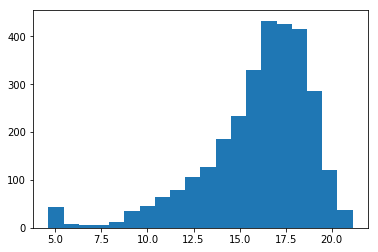

In [79]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.hist(np.log(train_df_raw.revenue + 100), bins=20)

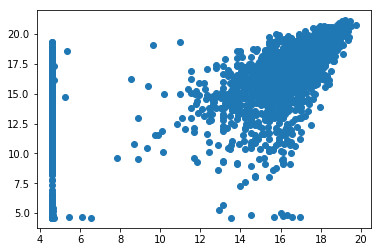

In [82]:
plt.scatter(np.log(train_df_raw.budget + 100), np.log(train_df_raw.revenue + 100))

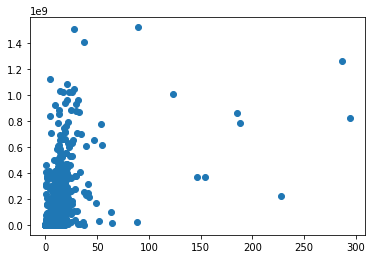

In [269]:
plt.scatter(train_df_raw.popularity, train_df_raw.revenue)

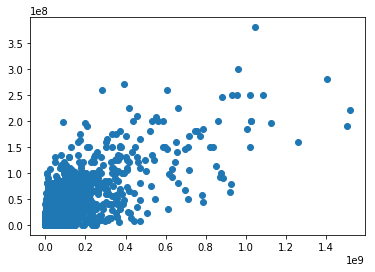

In [95]:
plt.scatter(train_df_raw.revenue, train_df_raw.budget)

# Train XGBoost and get R2 score on test set

In [265]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print("train/test constructed.")

# https://www.datacamp.com/community/tutorials/xgboost-in-python'
# TODO too many columns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# data_dmatrix = xgb.DMatrix(data=X,label=y)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 8, alpha = 10, n_estimators = 100)

print("Fitting...")
xg_reg.fit(X_train,y_train)
print("Predicting...")
preds = xg_reg.predict(X_test)
print("Calculating RMSE...")
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
np.corrcoef(y_test, preds)

from sklearn.metrics import r2_score
print("R2 score test: ", r2_score(y_test, preds))
print("R^2 score (train): ", r2_score(y_train, xg_reg.predict(X_train)))

train/test constructed.
Fitting...


/Users/mince/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predicting...
Calculating RMSE...
RMSE: 64068873.839877
R2 score test:  0.7503512924929838
R^2 score (train):  0.9594283780647136


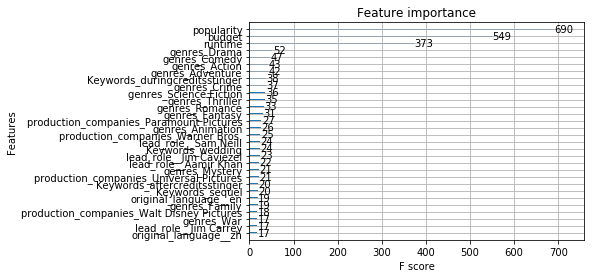

In [263]:
# plot feature importance
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(xg_reg, max_num_features=30)
plt.show()

That is a very, _very_ good feature importance graph. All the features make sense!

In [245]:
?xgb.XGBRegressor

Init signature:
xgb.XGBRegressor(
    ['max_depth=3', 'learning_rate=0.1', 'n_estimators=100', 'silent=True', "objective='reg:linear'", "booster='gbtree'", 'n_jobs=1', 'nthread=None', 'gamma=0', 'min_child_weight=1', 'max_delta_step=0', 'subsample=1', 'colsample_bytree=1', 'colsample_bylevel=1', 'reg_alpha=0', 'reg_lambda=1', 'scale_pos_weight=1', 'base_score=0.5', 'random_state=0', 'seed=None', 'missing=None', "importance_type='gain'", '**kwargs'],
)
Docstring:     
Implementation of the scikit-learn API for XGBoost regression.

Parameters
----------
max_depth : int
    Maximum tree depth for base learners.
learning_rate : float
    Boosting learning rate (xgb's "eta")
n_estimators : int
    Number of boosted trees to fit.
silent : boolean
    Whether to print messages while running boosting.
objective : string or callable
    Specify the learning task and the corresponding learning objective or
    a custom objective function to be used (see note below).
booster: string
    Specify w

In [229]:
# https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html
import numpy as np
import xgboost as xgb
from typing import Tuple

def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the gradient squared log error.'''
    y = dtrain.get_label()
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

def hessian(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the hessian for squared log error.'''
    y = dtrain.get_label()
    return ((-np.log1p(predt) + np.log1p(y) + 1) /
            np.power(predt + 1, 2))

def squared_log(predt: np.ndarray,
                dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess


def gradient_squared_log(predt, y):
        return (np.log1p(predt) - np.log1p(y)) / (predt + 1)
def hessian_squared_log(predt, y):
        return ((-np.log1p(predt) + np.log1p(y) + 1) /
            np.power(predt + 1, 2))
def squared_log_mince(predt, y):
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

def rmsle_mince(predt,y):
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

def rmsle(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    ''' Root mean squared log error metric.'''
    y = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

print("Done")


Done


# Classifier comparison

In [276]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print("train/test constructed.")

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.neural_network import MLPRegressor

# https://xgboost.readthedocs.io/en/latest/parameter.html#
# TODO squaredlogerror would be great here - log of budget is important
clfs = [
        (xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 60), "XGBoost linear tweaked 2", r2_score),
        (xgb.XGBRegressor(objective=squared_log_mince, colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 20), "XGBoost squared-log", rmsle_mince),
        (DummyRegressor(), "dummy", r2_score),
        (MLPRegressor(solver='lbfgs'), "Multi-layer perceptron", r2_score),
        (KNeighborsRegressor(), "KNN", r2_score),
        (KNeighborsRegressor(n_neighbors=10), "KNN, 10 neighbors", r2_score),
#         (LinearRegression(), "linear", r2_score),
        (RandomForestRegressor(n_estimators=60, max_depth=10), "Random Forest", r2_score),
#         (GaussianNB(), "Gaussian Naive Bayes", r2_score)
       ]

for clf, clf_name, objective in clfs:
    print ("For clf", clf_name, ":")
    print("Fitting...")
    model = clf.fit(X_train,y_train)
    print("Predicting...")
    preds = model.predict(X_test)
    print("Calculating RMSE...")
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("RMSE: %f" % (rmse))
    print("objective score test: ", objective(y_test, preds))
    print("objective (train): ", objective(y_train, xg_reg.predict(X_train)))
    print("Done.\n\n")

train/test constructed.
For clf XGBoost linear tweaked 2 :
Fitting...


/Users/mince/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predicting...
Calculating RMSE...
RMSE: 64280547.661839
objective score test:  0.7486989646987032
objective (train):  0.9594283780647136
Done.


For clf XGBoost squared-log :
Fitting...


/Users/mince/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predicting...
Calculating RMSE...
RMSE: 143636343.398798
objective score test:  ('PyRMSLE', 15.947794472189699)


/Users/mince/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log1p


objective (train):  ('PyRMSLE', 2.283714589867556)
Done.


For clf dummy :
Fitting...
Predicting...
Calculating RMSE...
RMSE: 128252318.453896
objective score test:  -0.00038135949268292
objective (train):  0.9594283780647136
Done.


For clf Multi-layer perceptron :
Fitting...
Predicting...
Calculating RMSE...
RMSE: 73652190.600186
objective score test:  0.6700816450940912
objective (train):  0.9594283780647136
Done.


For clf KNN :
Fitting...
Predicting...
Calculating RMSE...
RMSE: 80119538.829370
objective score test:  0.609598009813892
objective (train):  0.9594283780647136
Done.


For clf KNN, 10 neighbors :
Fitting...
Predicting...
Calculating RMSE...
RMSE: 74604270.789715
objective score test:  0.6614970008943499
objective (train):  0.9594283780647136
Done.


For clf Random Forest :
Fitting...
Predicting...
Calculating RMSE...
RMSE: 63999883.638559
objective score test:  0.7508886530055968
objective (train):  0.9594283780647136
Done.




In [ ]:
# TODO https://www.kaggle.com/residentmario/automated-feature-selection-with-sklearn
# Also lightgbm is faster
# https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# find best scored 5 features
select_feature = SelectKBest(chi2, k=5).fit(X_train, y_train)

print('Score list:', select_feature.scores_)
print('Feature list:', X_train.columns)



In [211]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif,chi2
#Suppose, we select 5 features with top 5 Fisher scores
selector = SelectKBest(chi2, k = 30)
#New dataframe with the selected features for later use in the classifier. fit() method works too, if you want only the feature names and their corresponding scores
X_new = selector.fit_transform(X, y)
names = X.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

                                           Feat_names      F_Scores
0                                              budget  1.817628e+11
1                                          popularity  5.157023e+04
2                                             runtime  1.218984e+04
14                              original_language__sr  2.999000e+03
5                               original_language__cs  2.999000e+03
4                               original_language__bn  2.999000e+03
15                              original_language__ur  2.999000e+03
16                              original_language__vi  2.999000e+03
3                               original_language__ar  2.999000e+03
9                               original_language__id  2.999000e+03
11                              original_language__nb  2.999000e+03
10                              original_language__mr  2.999000e+03
7                               original_language__he  2.999000e+03
17                                    genres_TV 

In [257]:
# from sklearn.feature_selection import RFE
# # Create the RFE object and rank each pixel
# clf_rf_3 = RandomForestRegressor()
# rfe = RFE(estimator=clf_rf_3, n_features_to_select=30, step=1)
# rfe = rfe.fit(X_train, y_train)

# print('Chosen best 5 feature by rfe:',X_train.columns[rfe.support_])



In [43]:
print("Fitting...")
xg_reg.fit(X_train,y_train)
print("Predicting...")
preds = xg_reg.predict(X_test)
print("Calculating RMSE...")
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))


Fitting...


/Users/mince/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Predicting...
Calculating RMSE...
RMSE: 93184649.038922


In [44]:
np.corrcoef(y_test, preds)

array([[1.        , 0.83410707],
       [0.83410707, 1.        ]])

In [ ]:
import lightgbm

?lightgbm.train

In [ ]:
# TODO https://www.kaggle.com/residentmario/automated-feature-selection-with-sklearn
# Also lightgbm is faster
# https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization

# https://www.kaggle.com/ezietsman/simple-python-lightgbm-example

import lightgbm


# I have no idea what this means
parameters = {
    'application': 'numeric',
    'objective': 'numeric',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lightgbm.train(parameters,
                       X_train,
                       valid_sets=y_train,
                       num_boost_round=5000,
                       early_stopping_rounds=100)
